# Convolutional Autoencoder with Progressive Image Compression
### Run Details : 200 epochs
###                 91.5% SSIM

## Dataset download

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import os

dataset_path = '/kaggle/input/stanford-dogs-dataset/images/Images'

# List subdirectories (breeds)
breeds = os.listdir(dataset_path)
print("Number of breeds:", len(breeds))
print("Example breeds:", breeds[:5])

# List files in one breed (adjust as needed)
breed_path = os.path.join(dataset_path, breeds[0])
images_in_breed = os.listdir(breed_path)
print("Number of images in one breed:", len(images_in_breed))
print("Example images:", images_in_breed[:5])


Number of breeds: 120
Example breeds: ['n02091635-otterhound', 'n02102318-cocker_spaniel', 'n02101388-Brittany_spaniel', 'n02088094-Afghan_hound', 'n02085936-Maltese_dog']
Number of images in one breed: 151
Example images: ['n02091635_965.jpg', 'n02091635_1329.jpg', 'n02091635_4698.jpg', 'n02091635_2120.jpg', 'n02091635_470.jpg']


### Viewing a sample

size img(500, 333, 3)
size img(388, 338, 3)
size img(333, 500, 3)
size img(491, 500, 3)
size img(375, 500, 3)
size img(334, 500, 3)
size img(500, 333, 3)
size img(343, 500, 3)
size img(375, 500, 3)


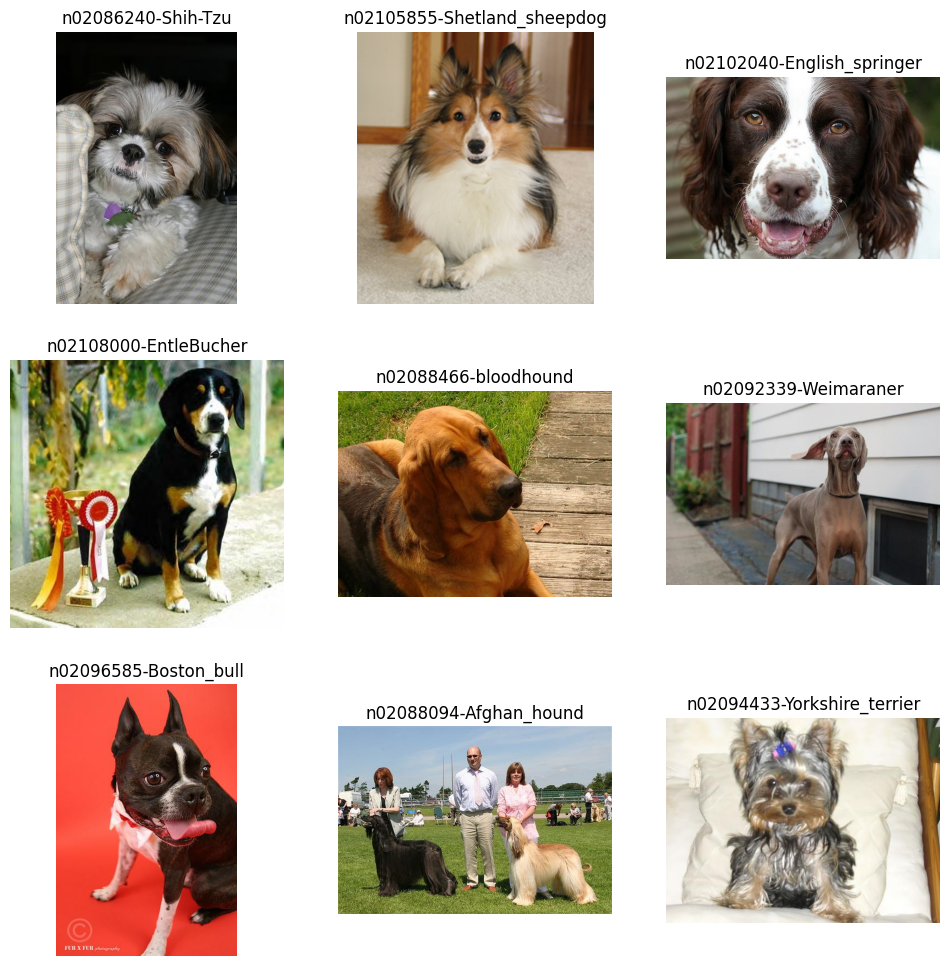

In [4]:
import matplotlib.pyplot as plt
from matplotlib.image import imread
import random

# Visualize random images from different breeds
num_rows = 3
num_cols = 3

plt.figure(figsize=(12, 12))

for i in range(num_rows * num_cols):
    breed = random.choice(breeds)
    breed_path = os.path.join(dataset_path, breed)
    image_file = random.choice(os.listdir(breed_path))
    image_path = os.path.join(breed_path, image_file)

    plt.subplot(num_rows, num_cols, i + 1)
    plt.imshow(imread(image_path))
    print(f"size img{imread(image_path).shape}")
    plt.title(breed)
    plt.axis('off')
channel_axis=2
plt.show()

In [5]:
import os
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split

### Dataloader config

In [6]:
from torchvision import transforms
from torch.utils.data import DataLoader, random_split
from PIL import Image
import torch
import torch.nn.functional as F


transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Adjust the size as needed
    transforms.ToTensor(),
])
def collate_fn_padd(batch):
    '''
    Padds batch of variable length

    note: it converts things ToTensor manually here since the ToTensor transform
    assume it takes in images rather than arbitrary tensors.
    '''
    ## get sequence lengths
    lengths = torch.tensor([ t.shape[0] for t in batch ]).to(device)
    ## padd
    batch = [ torch.Tensor(t).to(device) for t in batch ]
    batch = torch.nn.utils.rnn.pad_sequence(batch)
    ## compute mask
    mask = (batch != 0).to(device)
    return batch, lengths, mask


dataset = ImageFolder(root=dataset_path, transform=transform)

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

batch_size = 32 #set to 32 later
train_loader = DataLoader(train_dataset, batch_size=batch_size,
                          shuffle=True, num_workers=4)

test_loader = DataLoader(test_dataset, batch_size=8,
                         shuffle=False, num_workers=4)#look into collate fn

# Display batch
for images, targets in train_loader:
    print("Training Batch shape:", images.shape)
    break

Training Batch shape: torch.Size([32, 3, 256, 256])


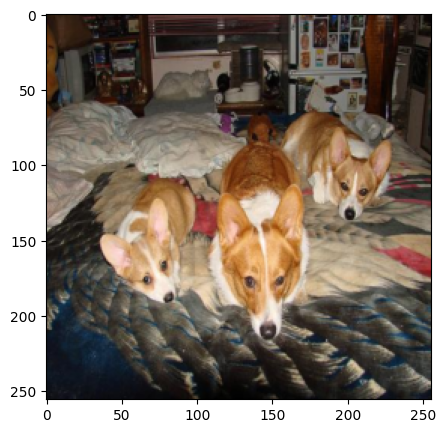

In [7]:
import numpy as np

# obtain one batch of training images
for images, labels in train_loader:
    break  # Get the first batch only

images = images.numpy()

# get one image from the batch and transpose the axes
img = np.transpose(images[0], (1, 2, 0))

fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)
ax.imshow(img)
plt.show()


## Building the network

In [8]:
import torch.nn as nn
import torch.nn.functional as F

In [9]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"GPU: {torch.cuda.get_device_name(0)}")
else:
    device = torch.device("cpu")
    print("No GPU available, using CPU.")

GPU: Tesla T4


### Attention Module

In [10]:
class AttentionModule(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(AttentionModule, self).__init__()

        # Convolutional layers to compute attention weights
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(out_channels, 1, kernel_size=3, padding=1)

        # Softmax to obtain attention weights
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        # Compute attention weights
        att = F.relu(self.conv1(x))
        att = self.conv2(att)
        att = self.softmax(att.view(att.size(0), -1)).view_as(att)

        # Multiply input by attention weights
        x = x * att

        return x

### Conv architecture

In [11]:
class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(channels)
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(channels)

    def forward(self, x):
        residual = x
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += residual
        out = F.relu(out)
        return out

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Encoder
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1)
        self.bottleneck = nn.Conv2d(256, 64, kernel_size=3, stride=1, padding=1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.bottleneck(x)
        return x

# Decoder
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.deconv1 = nn.ConvTranspose2d(64, 256, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.deconv2 = nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.deconv3 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.deconv4 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.deconv5 = nn.ConvTranspose2d(32, 3, kernel_size=3, stride=1, padding=1)

    def forward(self, x):
        x = F.relu(self.deconv1(x))
        x = F.relu(self.deconv2(x))
        x = F.relu(self.deconv3(x))
        x = F.relu(self.deconv4(x))
        x = torch.sigmoid(self.deconv5(x))
        return x

# Progressive Image Compression
class ProgressiveAutoEncoder(nn.Module):
    def __init__(self):
        super(ProgressiveAutoEncoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):
        # Encode the input image
        encoded = self.encoder(x)

        # Progressive decoding
        decoded = self.decoder(encoded)
        residual = x - decoded
        return decoded, residual

# Move model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ProgressiveAutoEncoder()
model = model.to(device)
print(model)

ProgressiveAutoEncoder(
  (encoder): Encoder(
    (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (bottleneck): Conv2d(256, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (decoder): Decoder(
    (deconv1): ConvTranspose2d(64, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (deconv2): ConvTranspose2d(256, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (deconv3): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (deconv4): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (deconv5): ConvTranspose2d(32, 3, kernel_size=(3, 3), stride=(1, 

### Model Training
TODO: add checkpoints

In [13]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 200
train_losses = []
for epoch in range(num_epochs):
    running_loss = 0.0
    for data in train_loader:
        images, _ = data
        images = images.to(device)

        decoded, residual = model(images)

        reconstruction_loss = criterion(decoded, images)
        residual_loss = criterion(residual, torch.zeros_like(residual))
        loss = reconstruction_loss + residual_loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    epoch_loss = running_loss / len(train_loader)
    train_losses.append(epoch_loss)

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.6f}')

Epoch [1/200], Loss: 0.016842
Epoch [2/200], Loss: 0.007769
Epoch [3/200], Loss: 0.007204
Epoch [4/200], Loss: 0.007536
Epoch [5/200], Loss: 0.004850
Epoch [6/200], Loss: 0.003569
Epoch [7/200], Loss: 0.005938
Epoch [8/200], Loss: 0.003397
Epoch [9/200], Loss: 0.005975
Epoch [10/200], Loss: 0.003529
Epoch [11/200], Loss: 0.005042
Epoch [12/200], Loss: 0.002555
Epoch [13/200], Loss: 0.002863
Epoch [14/200], Loss: 0.002945
Epoch [15/200], Loss: 0.003977
Epoch [16/200], Loss: 0.002779
Epoch [17/200], Loss: 0.002493
Epoch [18/200], Loss: 0.003405
Epoch [19/200], Loss: 0.003177
Epoch [20/200], Loss: 0.003618
Epoch [21/200], Loss: 0.002229
Epoch [22/200], Loss: 0.002512
Epoch [23/200], Loss: 0.002617
Epoch [24/200], Loss: 0.002558
Epoch [25/200], Loss: 0.001773
Epoch [26/200], Loss: 0.002898
Epoch [27/200], Loss: 0.002496
Epoch [28/200], Loss: 0.002848
Epoch [29/200], Loss: 0.002085
Epoch [30/200], Loss: 0.003590
Epoch [31/200], Loss: 0.001257
Epoch [32/200], Loss: 0.003102
Epoch [33/200], L

### Plotting the loss

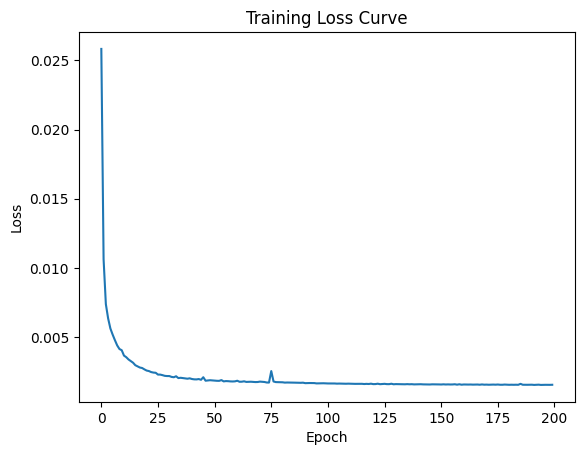

In [14]:
plt.figure()
plt.plot(range(num_epochs), train_losses)
plt.title('Training Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

### Saving the encoder and decoder weights separately

In [15]:
torch.save(model.encoder.state_dict(), 'PgIC_encoder_256x_200e.pth')
torch.save(model.decoder.state_dict(), 'PgIC_decoder_256x_200e.pth')

# Using the encoder-decoder

#### Load the models (switch to GPU)

In [16]:
encoder = Encoder()
encoder.load_state_dict(torch.load('PgIC_encoder_256x_200e.pth'))
encoder.eval()

decoder = Decoder()
decoder.load_state_dict(torch.load('PgIC_decoder_256x_200e.pth'))
decoder.eval()

Decoder(
  (deconv1): ConvTranspose2d(64, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  (deconv2): ConvTranspose2d(256, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  (deconv3): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  (deconv4): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  (deconv5): ConvTranspose2d(32, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

In [17]:
from torchvision.utils import make_grid

In [18]:
import time
timings = []

### Plotting the images, reconstructions and latent spaces

0.6297359466552734
compressed_size: torch.Size([8, 64, 16, 16])


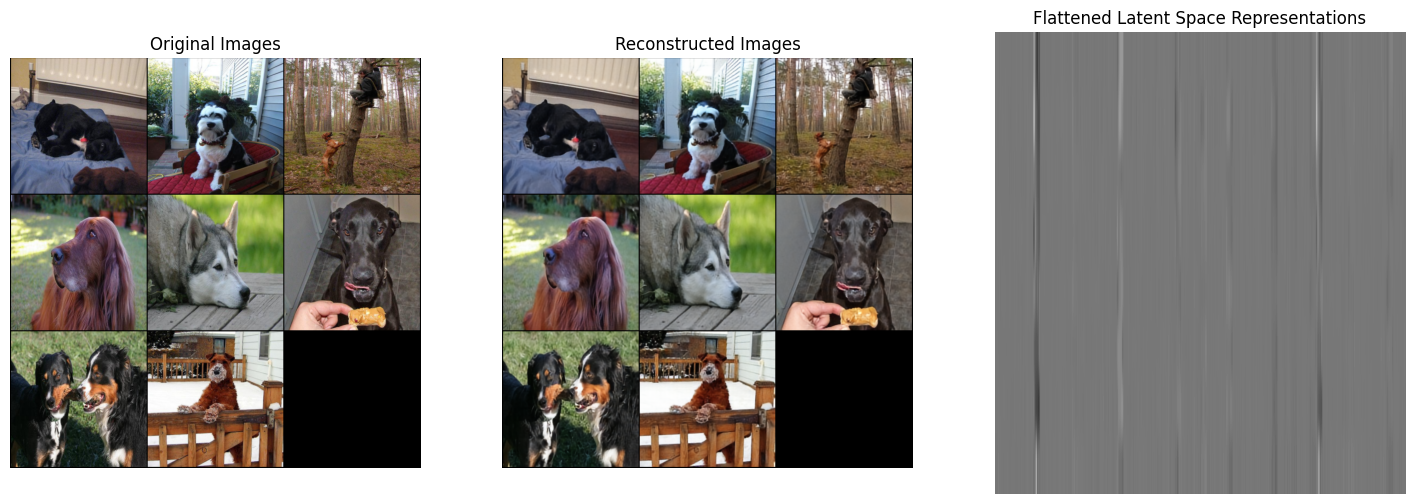

In [19]:
test_images, _ = next(iter(test_loader))

start_time = time.time()
compressed_representations = encoder(test_images)
reconstructed_images = decoder(compressed_representations)
end_time = time.time()
print(end_time - start_time)
print("compressed_size:", compressed_representations.shape)
# Flatten the latent space representations
flattened_latent = compressed_representations.detach().view(compressed_representations.size(0), -1)

# Create a grid of original, reconstructed, and latent space images
original_grid = make_grid(test_images, nrow=3, normalize=True)
reconstructed_grid = make_grid(reconstructed_images, nrow=3, normalize=True)

# Plot the results
fig, ax = plt.subplots(1, 3, figsize=(18, 6))

ax[0].imshow(np.transpose(original_grid.numpy(), (1, 2, 0)))
ax[0].set_title('Original Images')
ax[0].axis('off')

ax[1].imshow(np.transpose(reconstructed_grid.numpy(), (1, 2, 0)))
ax[1].set_title('Reconstructed Images')
ax[1].axis('off')

ax[2].imshow(flattened_latent.numpy(), cmap='gray', aspect='auto')
ax[2].set_title('Flattened Latent Space Representations')
ax[2].axis('off')

plt.show()

In [20]:
from skimage.metrics import structural_similarity as ssim

## Plotting the SSIMs of images over a batch of 16 samples from the test loader

(256, 256, 3)
(256, 256, 3)
0.94752437
(256, 256, 3)
(256, 256, 3)
0.90591496
(256, 256, 3)
(256, 256, 3)
0.8063434
(256, 256, 3)
(256, 256, 3)
0.93027574
(256, 256, 3)
(256, 256, 3)
0.9449002
(256, 256, 3)
(256, 256, 3)
0.94500375
(256, 256, 3)
(256, 256, 3)
0.9324505
(256, 256, 3)
(256, 256, 3)
0.9115961


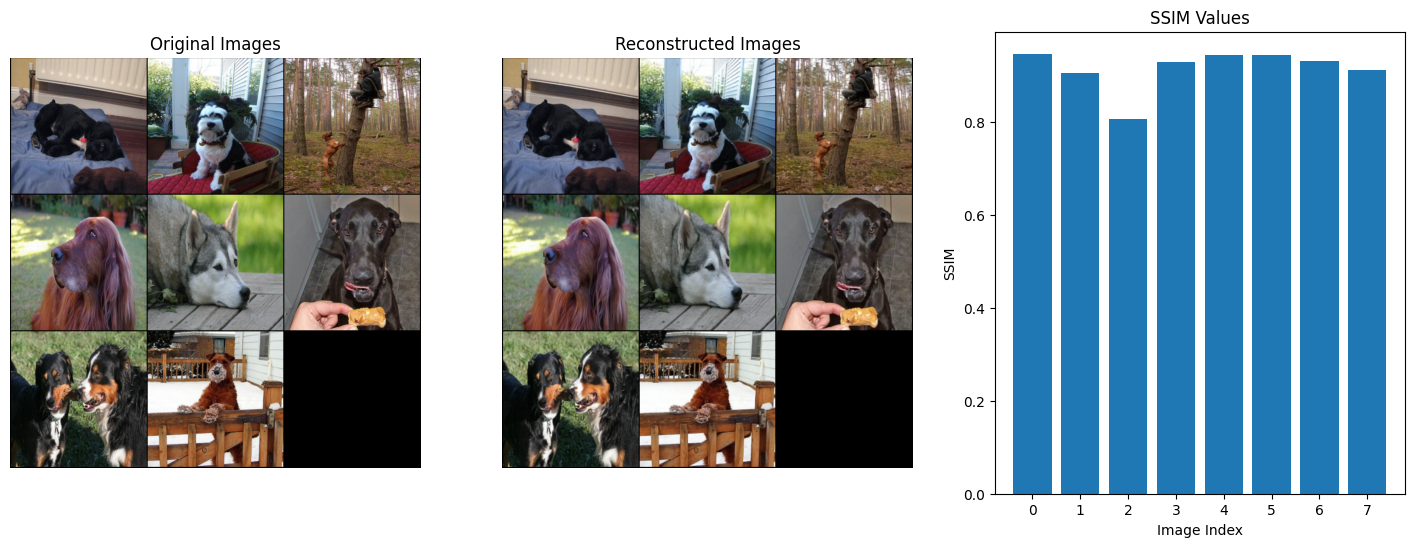

In [21]:
ssim_values = []
for orig_img, recon_img in zip(test_images, reconstructed_images):
    orig_img_np = orig_img.permute(1, 2, 0).detach().cpu().numpy()
    recon_img_np = recon_img.permute(1, 2, 0).detach().cpu().numpy()
    print(orig_img_np.shape)
    print(recon_img_np.shape)
    ssim_val = ssim(orig_img_np, recon_img_np, data_range=1.0, multichannel=True, channel_axis=2)
    print(ssim_val)
    ssim_values.append(ssim_val)

# Create a grid of original and reconstructed images
original_grid = make_grid(test_images, nrow=3, normalize=True)
reconstructed_grid = make_grid(reconstructed_images, nrow=3, normalize=True)

# Plot the results
fig, ax = plt.subplots(1, 3, figsize=(18, 6))

ax[0].imshow(np.transpose(original_grid.numpy(), (1, 2, 0)))
ax[0].set_title('Original Images')
ax[0].axis('off')

ax[1].imshow(np.transpose(reconstructed_grid.numpy(), (1, 2, 0)))
ax[1].set_title('Reconstructed Images')
ax[1].axis('off')

ax[2].bar(range(len(ssim_values)), ssim_values)
ax[2].set_title('SSIM Values')
ax[2].set_xlabel('Image Index')
ax[2].set_ylabel('SSIM')

plt.show()

In [22]:
s = 0
for i in ssim_values:
    s += i
print(s/len(ssim_values))

0.9155011251568794


### Average 0.915 SSIM
### Size of each latent space: 64 x 16 x 16